# Detectando Anomalias em imagens com o Amazon Lookout for Vision

Este notebook visa a implementação de um modelo capaz de reconhecer peças mecânicas com algum tipo de defeito em sua fabricação utilizando o serviço Amazon Lookout for Vision. O projeto implementado é parte de um blog post intitulado "Detectando Anomalias em imagens com Amazon Lookout for Vision", o qual explica os objetivos e os pontos mais importantes desta solução.

## Inicializando
Os primeiros passos para a criação do modelo consistem na importação das bibliotecas necessárias para a implementação do modelo, bem como o carregamento do dataset de imagens que serão utilizadas para o treinamento e testes.

A seguir, vamos incluir as bibliotecas ao projeto

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import io
import sagemaker.amazon.common as smac
import boto3
from sagemaker import get_execution_role
import sagemaker
import os

O dataset que será utilizado neste notebook foi disponibilizado publicamente pelo Kaggle [neste repositório](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product?select=casting_data)

Para carregarmos todas as imagens, deve-se primeiramente instalar o pacote de APIs Kaggle em sua máquina:

In [ ]:
!pip install kaggle

Em seguida, siga os seguintes passos:
1. Crie uma nova conta ou faça login utiizando uma conta pré-existente no Kaggle
2. Siga [este tutorial](https://medium.com/@jeff.daniel77/accessing-the-kaggle-com-api-with-jupyter-notebook-on-windows-d6f330bc6953) para criar um novo API token do Kaggle e utilizá-lo neste notebook
3. Faça o upload do token para o sistema de arquivos do SageMaker Studio
4. Abra uma instância do terminal no SageMaker Studio e execute o seguinte comando:

```
mkdir .kaggle
```

5. Mova o token para o diretório criado:

```
mv ./SageMaker/kaggle.json ./.kaggle
```

6. Acesse o [repositório de imagens no Kaggle](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product?select=casting_data)
7. Para copiar o comando da API de download do dataset, clique sobre os três pontos ao lado direito da tela. Em seguida, clique sobre "Copy API command"

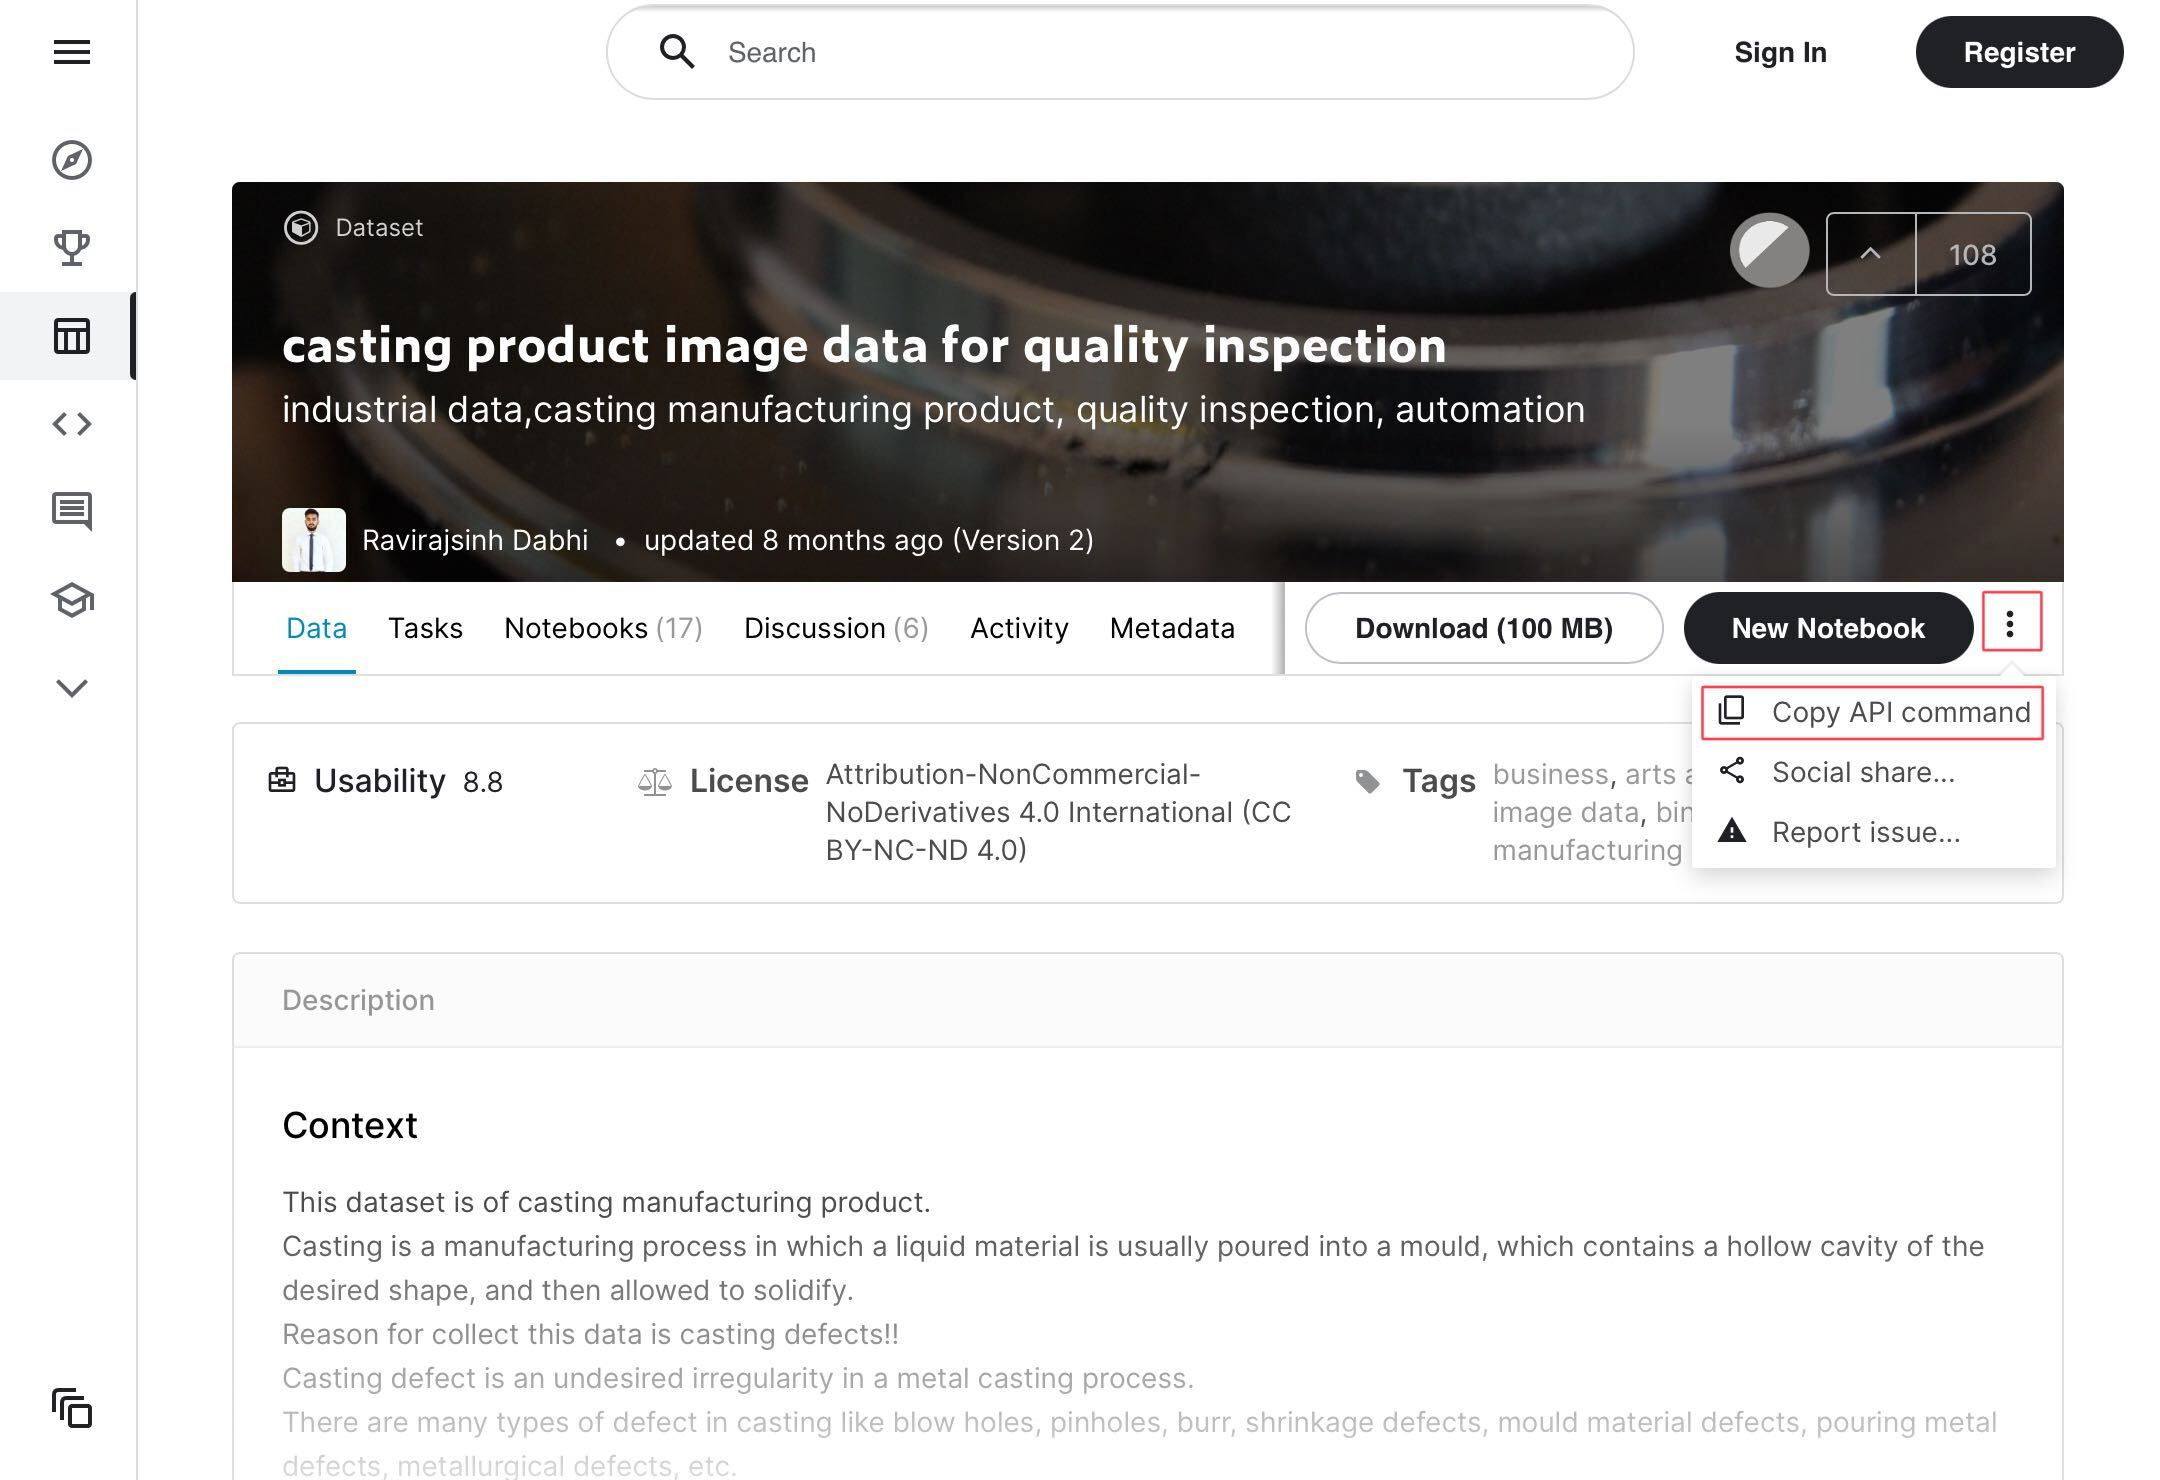

8. Cole o conteúdo copiado em uma nova célula do notebook e execute o comando como um shell command

In [ ]:
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product

Descompacte o arquivo baixado com as imagens do dataset

In [ ]:
!sudo yum install unzip -y
!unzip real-life-industrial-dataset-of-casting-product.zip

## Configurando o repositório das imagens no S3

A seguir, será necessário configurar um bucket do serviço Amazon S3 responsável para armazenar as imagens que serão utilizadas para treinamento, bem como rotulá-las entre imagens de peças normais e com anomalias.

Primeiramente, crir um novo bucket no qual as imagens serão salvas e o nome para o projeto. 

**Obs:** substitua *NOME_DO_BUCKET* pelo nome do bucket criado

In [ ]:
BUCKET_NAME = 'NOME_DO_BUCKET'
PROJECT_NAME = 'manufacturing'

Em seguida, faça o upload das imagens baixadas no Amazon S3

In [ ]:
!aws s3 cp ./casting_data/ s3://datasets-sagemaker-ml/ --recursive

## Rotulando as imagens

Em seguida, será necessário criar um rótulo para as imagens.

Este rótulo é definido por um manifest file, que indica as classes de cada uma das imagens a fim de diferenciá-las durante o processo de treinamento e de testes. O bloco a seguir cria um manifest file automaticamente para ambos os grupos.

Para mais informações, acesse este link: https://docs.aws.amazon.com/lookout-for-vision/latest/developer-guide/manifest-files.html

In [ ]:
# Create manifest File

# Datetime for datetime generation and json to dump the JSON object
# to the corresponding files:
from datetime import datetime
import json

# Current date and time in manifest file format:
now = datetime.now()
dttm = now.strftime("%Y-%m-%dT%H:%M:%S.%f")

# The two datasets used: train and test
datasets = ["train", "test"]

# For each dataset...
for ds in datasets:
    # ...list the folder available (normal or anomaly).
    print(ds)
    folders = os.listdir("./casting_data/casting_data/{}".format(ds))
    # Then open the manifest file for this dataset...
    with open("{}.manifest".format(ds), "w") as f:
        for folder in folders:
            filecount=0
            print(folder)
            # ...and iterate through both folders by first listing
            # the corresponding files and setting the appropriate label
            # (as noted above: 1 = good, 0 = bad):
            files = os.listdir("./casting_data/casting_data/{}/{}".format(ds, folder))
            label = 1
            class_name = 'normal'
            if folder == "def_front":
                class_name = 'anomaly'
                label = 0
            # For each file in the folder...
            for file in files:
                # ...generate a manifest JSON object and save it to the manifest
                # file. Don't forget to add '/n' to generate a new line:
                manifest = {
                  "source-ref": "s3://{}/{}/{}/{}/{}".format(BUCKET_NAME, 'casting_data', ds, folder, file),
                  "auto-label": label,
                  "auto-label-metadata": {
                    "confidence": 1,
                    "job-name": "labeling-job/auto-label",
                    "class-name": class_name,
                    "human-annotated": "yes",
                    "creation-date": dttm,
                    "type": "groundtruth/image-classification"
                  }
                }
                f.write(json.dumps(manifest)+"\n")

Agora, faça o upload dos manifest files em seus respectivos diretórios

In [ ]:
!aws s3 cp train.manifest s3://datasets-sagemaker-ml/train.manifest
!aws s3 cp test.manifest s3://datasets-sagemaker-ml/test.manifest

## Criando o modelo

Com os canais de treinamento e de teste criados no S3, inicie o treinamento do modelo.

Para isso, crie um novo cliente para o Lookout for Vision e inicie um novo projeto

In [ ]:
client = boto3.Session().client('lookoutvision')

print('Creating project:' + PROJECT_NAME)
response=client.create_project(ProjectName=PROJECT_NAME)
print('project ARN: ' + response['ProjectMetadata']['ProjectArn'])
print('Done!')

Em seguida, crie os datasets de treinamento e de testes a partir das imagens armazenadas no S3

Para mais informações sobre a API decriação de datasets, [acesse sua documentação oficial](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/lookoutvision.html#LookoutforVision.Client.create_dataset)

In [ ]:
# DATASET DE TREINAMENTO
dataset_type ='train'
manifest_file = 'train.manifest'

print('Creating dataset...')
dataset=json.loads('{ "GroundTruthManifest": { "S3Object": { "Bucket": "' + BUCKET_NAME + '", "Key": "'+ manifest_file + '" } } }')

response=client.create_dataset(ProjectName=PROJECT_NAME, DatasetType=dataset_type, DatasetSource=dataset)
print('Dataset Status: ' + response['DatasetMetadata']['Status'])
print('Dataset Status Message: ' + response['DatasetMetadata']['StatusMessage'])
print('Dataset Type: ' + response['DatasetMetadata']['DatasetType'])
print('Done!')

In [ ]:
# DATASET DE TESTES
dataset_type ='test'
manifest_file = 'test.manifest'

print('Creating dataset...')
dataset=json.loads('{ "GroundTruthManifest": { "S3Object": { "Bucket": "' + BUCKET_NAME + '", "Key": "'+ manifest_file + '" } } }')

response=client.create_dataset(ProjectName=PROJECT_NAME, DatasetType=dataset_type, DatasetSource=dataset)
print('Dataset Status: ' + response['DatasetMetadata']['Status'])
print('Dataset Status Message: ' + response['DatasetMetadata']['StatusMessage'])
print('Dataset Type: ' + response['DatasetMetadata']['DatasetType'])
print('Done!')

Em seguida, inicie o treinamento do modelo:

In [ ]:
output_bucket = BUCKET_NAME
output_folder = 'model/'

    
print('Creating model...')
output_config=dataset=json.loads('{ "S3Location": { "Bucket": "' + output_bucket + '", "Prefix": "'+ output_folder + '" } } ')

response=client.create_model(ProjectName=PROJECT_NAME, OutputConfig=output_config)
print('ARN: ' + response['ModelMetadata']['ModelArn'])
print('Version: ' + response['ModelMetadata']['ModelVersion'])
print('Status: ' + response['ModelMetadata']['Status'])
print('Message: ' + response['ModelMetadata']['StatusMessage'])
print('Done!')

# Acompanhe a conclusão do treinamento
import time

while client.describe_model(ProjectName=PROJECT_NAME,ModelVersion='2')['ModelDescription']['Status']!='TRAINED':
    print('.',end='');time.sleep(5);
print('Done!')

## Disponibilizando o modelo

Uma vez que o treinamento tenha concluído devidamente, disponibilize o modelo para inferências.

Dessa forma, será criado um endpoint pelo qual será possível informar uma imagem de uma peça e classificá-la como uma peça normal ou com algum tipo de anomalia.

In [ ]:
model_version='1'
min_inference_units=1 
    
print('Starting model version ' + model_version  + ' for project ' + PROJECT_NAME )
response=client.start_model(ProjectName=PROJECT_NAME,
    ModelVersion=model_version,
    MinInferenceUnits=min_inference_units)
print('Status: ' + response['Status'])

# Acompanhe a disponibilização do modelo
while client.describe_model(ProjectName=PROJECT_NAME,ModelVersion = model_version)['ModelDescription']['Status']!='HOSTED':
    print('.',end='');time.sleep(5);
print('Done!')

## Realizando inferências

Com o modelo disponível em um endpoint, testeos resultados utilizando duas imagens de exemplo

In [ ]:
# Selecione uma peça anomala
photo='extra-images/cast_def_0_1635.jpeg'
    
with open(photo, 'rb') as image:
    response = client.detect_anomalies(ProjectName=PROJECT_NAME, 
    ContentType='image/jpeg',
    Body=image.read(),
    ModelVersion=model_version)
print ('Anomalous?: ' + str(response['DetectAnomalyResult']['IsAnomalous']))
print ('Confidence: ' + str(response['DetectAnomalyResult']['Confidence']))

In [ ]:
# Selecione uma peça normal
photo='extra-images/cast_ok_0_45.jpeg'
    
with open(photo, 'rb') as image:
    response=client.detect_anomalies(ProjectName=PROJECT_NAME, 
    ContentType='image/jpeg',
    Body=image.read(),
    ModelVersion=model_version)
print ('Anomalous?: ' + str(response['DetectAnomalyResult']['IsAnomalous']))
print ('Confidence: ' + str(response['DetectAnomalyResult']['Confidence']))

## Encerrando os recursos

Ao final da atividade, não se esqueça de encerrar os recursos criados!

In [ ]:
print('Stopping model version ' + model_version  + ' for project ' + PROJECT_NAME )
response=client.stop_model(ProjectName=project,
    ModelVersion=model_version)
print('Status: ' + response['Status'])